# Neural style transfer

Neural style transfer provide a way to compose one image in the style of another image and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

Neural style transfer is an optimization technique used to take two images

·A content image **($c$)** - the image we want to transfer a style to

·A style image **($s$)** - the image we want to transfer the style from

·A generated image **($g$)** - the image that contains the final result **(Only the trainable variables)**

![](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/613ebfc73d78bd3ecbe775c3_neural-style-transfer-model-architecture.png)

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

## Setup


### Import and configure modules

In [1]:
import os
import tensorflow as tf

In [42]:
if input("Are you using Google Colab? y/n") in ['y','Y']:
    from google.colab import auth
    auth.authenticate_user()
    from googleapiclient.discovery import build
    drive_service = build('drive', 'v3')
    from google.colab import drive
    drive.mount('/content/drive', force_remount= True)
    input_art_dir='/content/drive/My Drive/Data/gwp.jpg'
    target_photo_dir='/content/drive/My Drive/Data/photo.jpg'
else:
    input_art_dir='/Users/bryton/Desktop/Data/monet/monet_jpg'
    target_photo_dir='/Users/bryton/Desktop/Data/monet/photo_jpg'

# input_art_paths = sorted(
#     [os.path.join(input_art_dir, fname)
#      for fname in os.listdir(input_art_dir)
#      if fname.endswith(".jpg")])
# input_photo_paths = sorted(
#     [os.path.join(target_photo_dir, fname)
#      for fname in os.listdir(target_photo_dir)
#      if fname.endswith(".jpg")])

Are you using Google Colab? y/ny
Mounted at /content/drive


In [43]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [44]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [45]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img

rand_photo = random.randint(0, 7038)
rand_art = random.randint(0, 300)

# Get content and style images
# content_path = input_photo_paths[rand_photo]
content_path = target_photo_dir
style_path = input_art_dir
# style_path = style_art_path = input_art_paths[rand_art]

width, height = load_img(content_path).size
print(f"Input image dimensions: {width, height}")

Input image dimensions: (2232, 3296)


## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [46]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

Create a simple function to display an image:

In [47]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

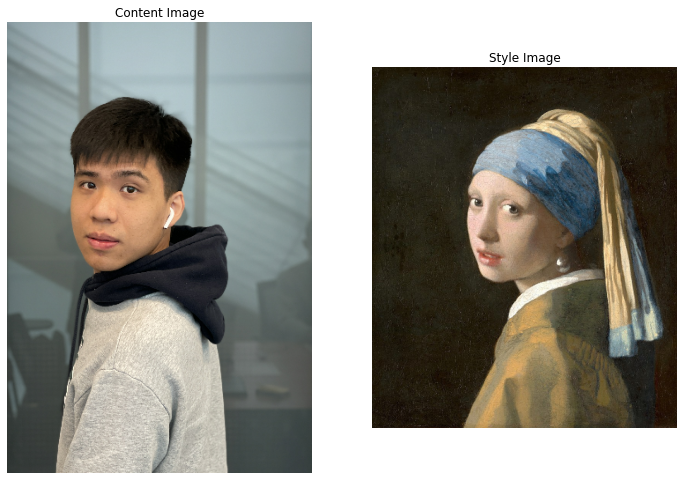

In [48]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
plt.axis('off')
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
plt.axis('off')
imshow(style_image, 'Style Image')

## Define content and style representations

Use the intermediate layers of the model to get the **content** and **style** representations of the image. 

Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:

In [49]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [50]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('bath_towel', 0.31299004),
 ('sweatshirt', 0.113065645),
 ('cardigan', 0.07907352),
 ('stole', 0.07421011),
 ('bow_tie', 0.045500882)]

Now load a **`VGG19`** without the classification head, and list the layer names

In [51]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [52]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Bulid the model

In [53]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

And to create the model:

In [54]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 512, 432, 64)
  min:  0.0
  max:  834.94696
  mean:  15.054224

block2_conv1
  shape:  (1, 256, 216, 128)
  min:  0.0
  max:  3349.3777
  mean:  79.56412

block3_conv1
  shape:  (1, 128, 108, 256)
  min:  0.0
  max:  5733.2734
  mean:  75.638954

block4_conv1
  shape:  (1, 64, 54, 512)
  min:  0.0
  max:  17868.201
  mean:  343.67154

block5_conv1
  shape:  (1, 32, 27, 512)
  min:  0.0
  max:  2880.8413
  mean:  28.185411



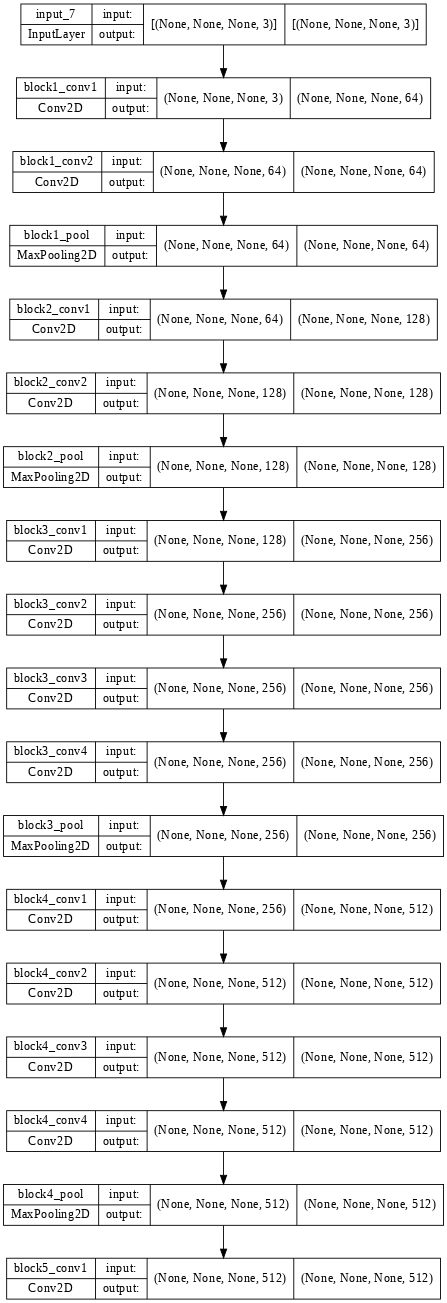

In [55]:
tf.keras.utils.plot_model(style_extractor, show_shapes = True, dpi = 64)

## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [56]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [57]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        """Expects float input in [0,1]"""
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [58]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00640704
    max:  24530.838
    mean:  236.14975

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  35593.652
    mean:  6713.3906

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.06298037
    max:  117214.76
    mean:  6619.504

   block4_conv1
    shape:  (1, 512, 512)
    min:  9.9803
    max:  1107408.4
    mean:  110416.89

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  166192.5
    mean:  1353.5493

Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  1485.8557
    mean:  12.757799


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [59]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [60]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [61]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [62]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

## The *Style Loss* , *Content Loss* and *Total Loss*

Let $A^l_{ij}(I)$ be the activation of the $l$ th layer, $i$ th feature map and $j$ th position obtained using the image I. The **Content Loss** function can be defined as follows:

$$L_{content} = \frac{1}{2}{\sum_{ij} (A^l_{ijc}(I)-A^l_{ijd}(I))^2}$$

Essentially $L_{content}$ captures the root mean squared error between the activations produced by the generated image and the content image. 

Similarly we can define **Style Loss** as:

$$L_{Style} = \frac{1}{2}{\sum_{ij} (G^l_{ijc}(I)-G^l_{ijd}(I))^2}$$

where $G^l_{ij}(I)$ be the **Gram_matrix** output of the $l$ th layer

Putting two together:

$$L_{Total} = \alpha*L_{content} + \beta*L_{Style}$$

Where $\alpha$ and $\beta$ is the weight of content loss and style loss in total loss function

In [63]:
style_weight=1e-2
content_weight=1e4

In [64]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## *Total variation loss*

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. 

In style transfer, this is often called the *total variation loss*, which is a regularization loss to keep the generated image locally coherent.

In [65]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

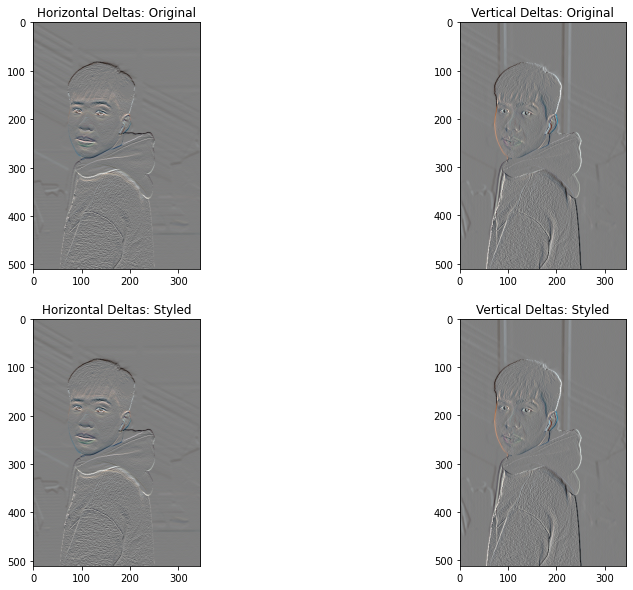

In [66]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

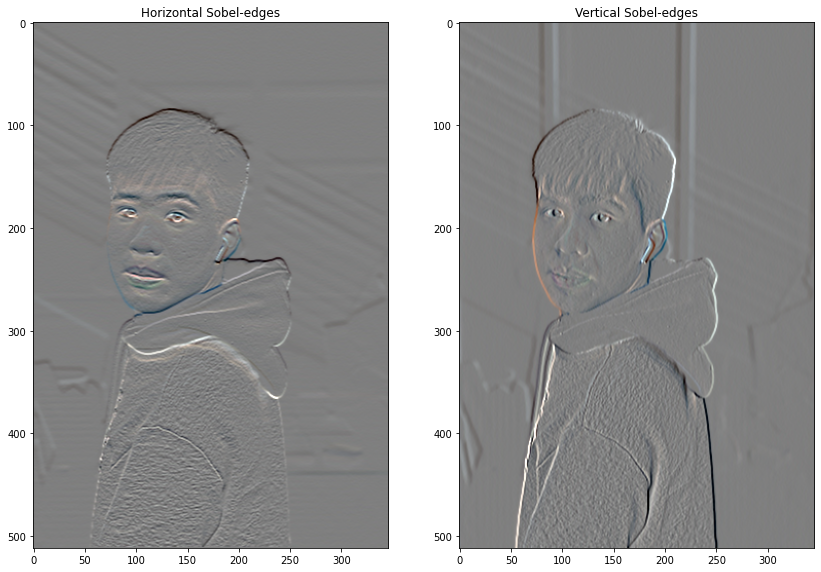

In [67]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [68]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [69]:
total_variation_loss(image).numpy()

18142.285

Choose a weight for the `total_variation_loss`:

In [70]:
total_variation_weight=30

Again, Total loss is defined as:

$$L_{Total} = \alpha*L_{content} + \beta*L_{Style} + \theta*L_{TotalVariationLoss}$$

Now include it in the `train_step` function:

In [71]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [72]:
image = tf.Variable(content_image)

And run the optimization:

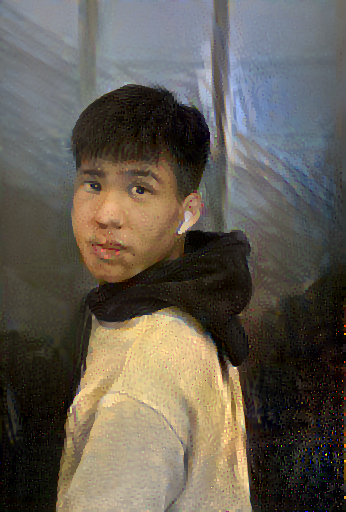

Train step: 1900
......................................................

KeyboardInterrupt: ignored

In [76]:
import time
start = time.time()

epochs = 100
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Take a look on three pictures together

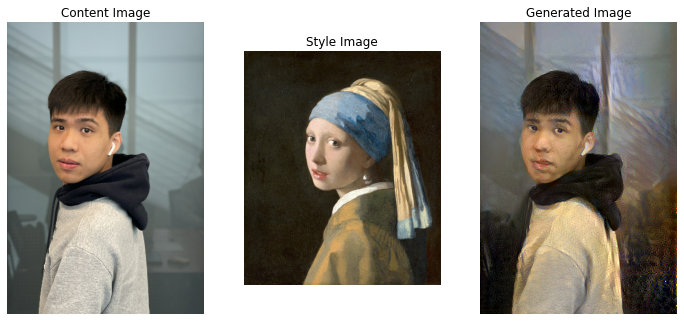

In [74]:
plt.subplot(1, 3, 1)
plt.axis('off')
imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
plt.axis('off')
imshow(style_image, 'Style Image')

plt.subplot(1, 3, 3)
plt.axis('off')
imshow(image, 'Generated Image')